# 1. Cài đặt và import thư viện

In [1]:

!pip install -q tensorflow keras-tuner pandas scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.4 MB/s eta 0:00:00


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch


# 2. Đọc dữ liệu & Xử lý đặc trưng

In [3]:
# Đọc file CSV và chuyển cột Date về kiểu datetime
df = pd.read_csv('/content/sample_data/BTC_Data_final.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Log transform để giảm skew của các cột có giá trị lớn.
df['log_marketcap'] = np.log1p(df['marketcap'])
df['log_transactionvalue'] = np.log1p(df['transactionvalue'])
df['log_tweets'] = np.log1p(df['tweets'])

# Tạo đặc trưng tỷ lệ. Dùng giá BTC của ngày hôm trước (lag) để dự báo hôm nay.
df['fee_to_reward_ratio'] = df['fee_to_reward'] / (df['mining_profitability'] + 1e-6)
# Tạo đặc trưng độ trễ (lag): dùng giá BTC của ngày hôm trước (lag) để dự báo hôm nay.
df['priceUSD_t-1'] = df['priceUSD'].shift(1)
df.dropna(inplace=True) # Xoá các dòng bị thiếu sau khi shift.

# Tách X (feature) và y (target)
X = df.drop(columns=['Date', 'priceUSD'])
y = df['priceUSD'].values.reshape(-1, 1)


# 3. Tách tập Train/Validation/Test và chuẩn hóa

In [4]:
# Chia dữ liệu thành 80% Train, 10% Validation, 10% Test
n = len(X)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

X_train_raw, X_val_raw, X_test_raw = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_train_raw, y_val_raw, y_test_raw = y[:train_end], y[train_end:val_end], y[val_end:]

# Chuẩn hóa giá trị về [0, 1] để mạng học dễ hơn.
scaler_X = MinMaxScaler().fit(X_train_raw)
scaler_y = MinMaxScaler().fit(y_train_raw)

X_train = scaler_X.transform(X_train_raw)
X_val = scaler_X.transform(X_val_raw)
X_test = scaler_X.transform(X_test_raw)

y_train = scaler_y.transform(y_train_raw)
y_val = scaler_y.transform(y_val_raw)
y_test = scaler_y.transform(y_test_raw)

# LSTM yêu cầu đầu vào là 3 chiều: (samples, time_steps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


# 4. Tạo mô hình với Keras Tuner

In [5]:
# Dùng Keras Tuner để thử các siêu tham số (hyperparameters)
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', 32, 128, step=32), activation='relu', input_shape=(1, X_train.shape[1]))) # Số node LSTM (units) được chọn từ 32–128
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1))) # Thử dropout từ 0.1 → 0.5 để tránh overfitting
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])), # Chọn learning rate tốt nhất từ 1e-2 → 1e-4
        loss='mse'
    )
    return model

# Dò tìm mô hình tốt nhất: Tuner sẽ thử 20 mô hình khác nhau, và chọn ra mô hình có val_loss thấp nhất.
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='lstm_tuner',
    project_name='btc_lstm'
)
tuner.search(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val),
             epochs=50, batch_size=32, callbacks=[EarlyStopping(patience=5)], verbose=1)

best_model = tuner.get_best_models(1)[0]


Trial 50 Complete [00h 00m 08s]
val_loss: 0.021286118775606155

Best val_loss So Far: 0.0006128562963567674
Total elapsed time: 00h 13m 57s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test MAE: 596.77
Test RMSE: 835.25
Test R2: 0.9925
Test MSE: 697639.14
Test MAPE: 2.28%
    Actual     Predicted
0  43854.0  44791.933594
1  43922.0  46169.312500
2  44331.0  46074.257812
3  43185.0  44540.570312
4  42333.0  43309.101562
5  42336.0  42220.761719
6  42232.0  43667.667969
7  43867.0  43608.011719
8  43998.0  44305.023438
9  42666.0  43544.921875


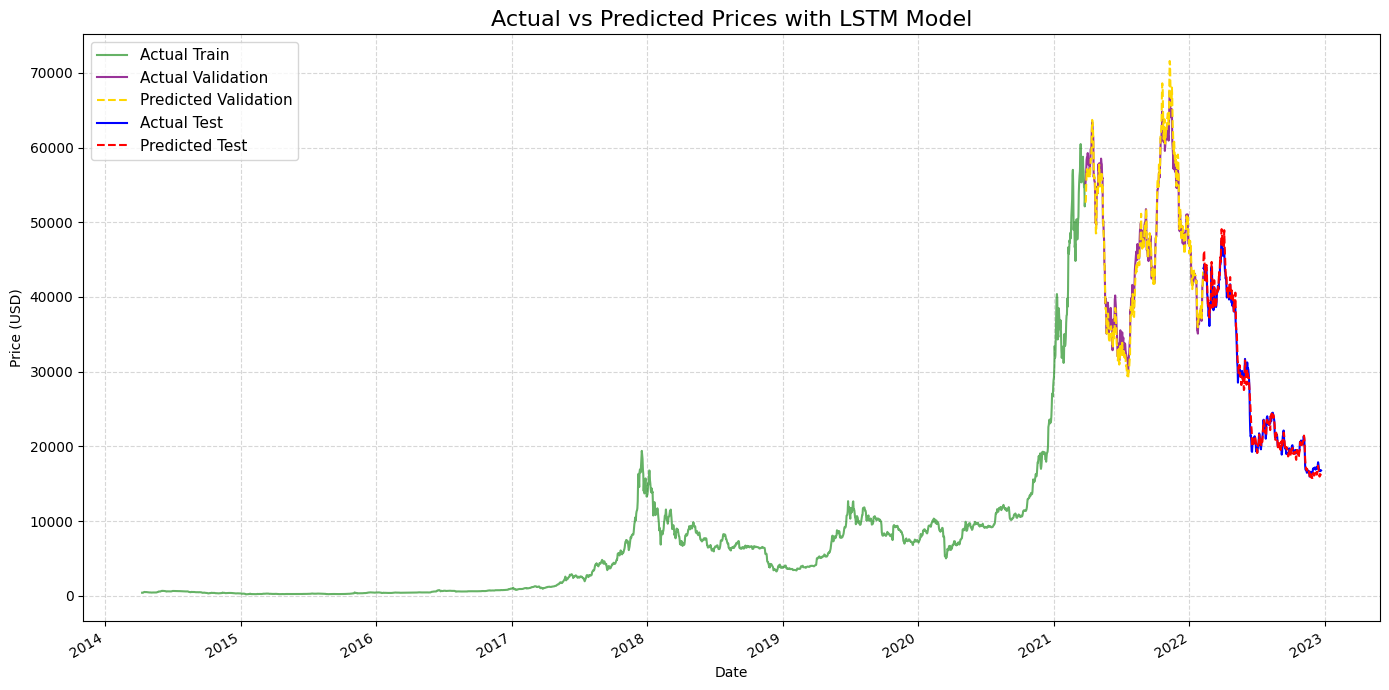

In [6]:

y_train_pred = best_model.predict(X_train_lstm)
y_val_pred = best_model.predict(X_val_lstm)
y_test_pred = best_model.predict(X_test_lstm)

y_train_true = scaler_y.inverse_transform(y_train)
y_val_true = scaler_y.inverse_transform(y_val)
y_test_true = scaler_y.inverse_transform(y_test)

y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
y_val_pred_inv = scaler_y.inverse_transform(y_val_pred)
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)

mae = mean_absolute_error(y_test_true, y_test_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred_inv))
r2 = r2_score(y_test_true, y_test_pred_inv)
mse = mean_squared_error(y_test_true, y_test_pred_inv)
mape = np.mean(np.abs((y_test_true - y_test_pred_inv) / y_test_true)) * 100

print(f"Test MAE: {mae:.2f}") # Sai số tuyệt đối trung bình
print(f"Test RMSE: {rmse:.2f}") # Căng hơn với sai số lớn
print(f"Test R2: {r2:.4f}") # Mức độ giải thích của mô hình
print(f"Test MSE: {mse:.2f}") # Sai số bình phương
print(f"Test MAPE: {mape:.2f}%") # Phần trăm sai số trung bình

# Bảng kết quả
results = pd.DataFrame({
    'Actual': y_test_true.flatten(),
    'Predicted': y_test_pred_inv.flatten()
})
print(results.head(10))

# Vẽ biểu đồ
train_dates = df['Date'].iloc[:train_end]
val_dates = df['Date'].iloc[train_end:val_end]
test_dates = df['Date'].iloc[val_end:]

plt.figure(figsize=(14, 7))
plt.plot(train_dates, y_train_true.flatten(), label='Actual Train', color='green', alpha=0.6)
plt.plot(val_dates, y_val_true.flatten(), label='Actual Validation', color='purple', alpha=0.8)
plt.plot(val_dates, y_val_pred_inv.flatten(), label='Predicted Validation', color='gold', linestyle='--')
plt.plot(test_dates, y_test_true.flatten(), label='Actual Test', color='blue')
plt.plot(test_dates, y_test_pred_inv.flatten(), label='Predicted Test', color='red', linestyle='--')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.title('Actual vs Predicted Prices with LSTM Model', fontsize=16)
plt.xlabel('Date'); plt.ylabel('Price (USD)')
plt.legend(fontsize=11); plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


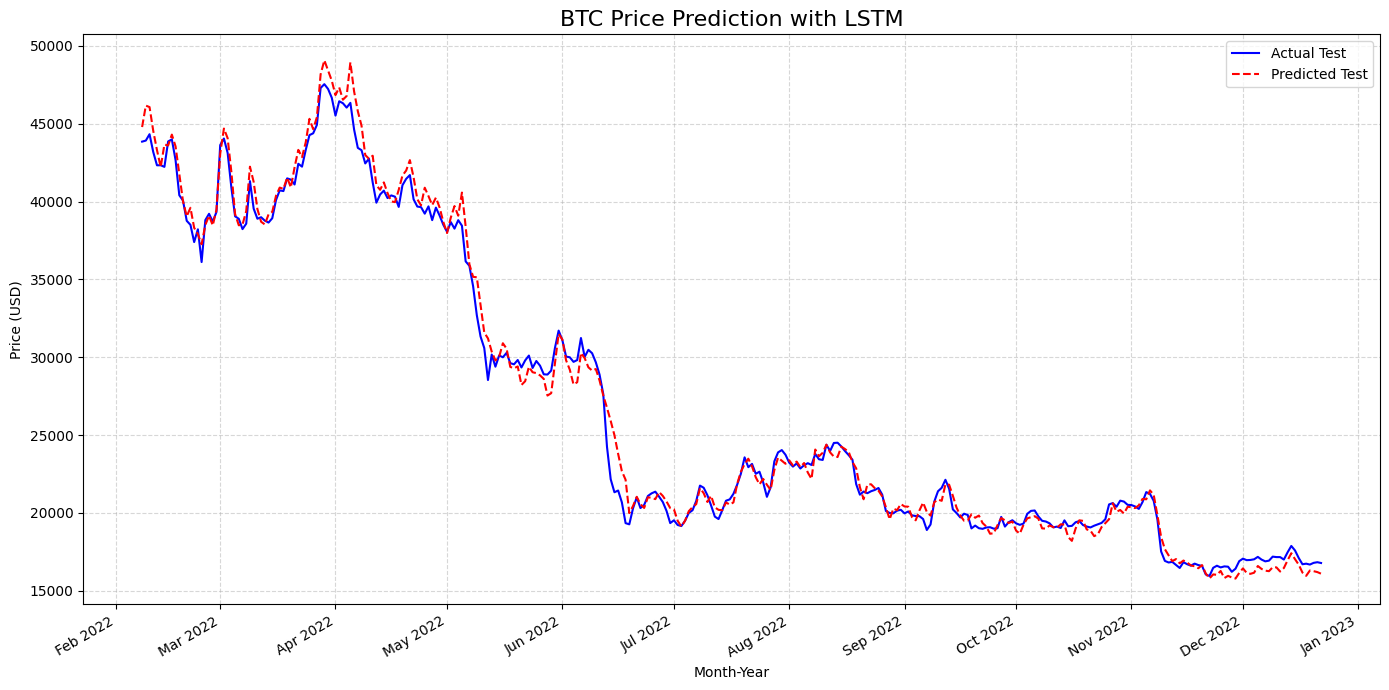

In [7]:
# Vẽ biểu đồ BTC Price Prediction with LSTM + Keras Tuner
test_dates = df['Date'].iloc[val_end:]
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_true.flatten(), label='Actual Test', color='blue')
plt.plot(test_dates, y_test_pred_inv.flatten(), label='Predicted Test', color='red', linestyle='--')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
plt.title('BTC Price Prediction with LSTM', fontsize=16)
plt.xlabel('Month-Year'); plt.ylabel('Price (USD)')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()